### Imports

In [4]:
from functions.load_data import load_CIFAR_data, load_Google_Digit_Data, load_MNIST_data, shuffle_data
from functions.attacks import attackTestSetBatch
from functions.models import simple_3layer_conv_relu_model, simple_3layer_conv_trop_model
from tensorflow.keras import losses
import numpy as np
from tensorflow.keras.utils import plot_model
from custom_layers.tropical_layers import TropConv2D
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, MaxPooling2D, Flatten, Conv2D
from tensorflow.keras import initializers
import csv
import os
from pathlib import Path

os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'  # Modify this path to your Graphviz installation directory

### LOAD DATA

In [5]:
# -- load SVHN data --
x_train, x_test, y_train, y_test = load_Google_Digit_Data(desired_classes=[i for i in range(10)])
x_train = x_train.reshape(-1,32,32,3)
x_test = x_test.reshape(-1,32,32,3)

### TROPICAL: Basic 3 convolutional layers model

In [ ]:
file_path = "output_data/MNIST_relu_conv_results_30step.csv"  # Replace with the file path you want to check
if not Path(file_path).is_file():
    with open(file_path, 'a', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(['pre_loss', 'pre_acc', 'post_loss', 'post_acc', 'maintained_correct_pred'])

for i in range(30):
    # -- Shuffle Data --
    x_train, x_test, y_train, y_test = shuffle_data(x_train, x_test, y_train, y_test)
    
    # -- TROPICAL: fit model --
    trop_model = simple_conv_trop_model(x_train=x_train, y_train=y_train, num_epochs=10)

    # -- TROPICAL: attack model -- 
    trop_x_test_att = attackTestSetBatch(trop_model, x_test, y_test, loss_object=losses.CategoricalCrossentropy(),modelName='Tropical', num_steps=30)

    # -- TROPICAL: evaluate -- 
    # - before attack -
    pre_trop_preds = np.argmax(trop_model.predict(x_test), axis=1)
    y_tester = np.argmax(y_test, axis=1)
    pre_correct_index = np.equal(pre_trop_preds, y_tester)
    pre_loss, pre_acc = trop_model.evaluate(x_test, y_test)

    # - after attack - 
    post_trop_preds = np.argmax(trop_model.predict(trop_x_test_att), axis=1)
    post_loss, post_acc = trop_model.evaluate(trop_x_test_att, y_test)

    # - number maintaining prediction - 
    maintained_correct_pred = np.average(np.equal(post_trop_preds[pre_correct_index], y_tester[pre_correct_index]))

    data = [pre_loss, pre_acc, post_loss, post_acc, maintained_correct_pred]
    with open(file_path, 'a', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(data)

In [ ]:
pre_trop_preds = np.argmax(trop_model.predict(x_test), axis=1)
y_tester = np.argmax(y_test, axis=1)
pre_correct_index = np.equal(pre_trop_preds, y_tester)
pre_loss, pre_acc = trop_model.evaluate(x_test, y_test)

for i in range(1,150):
    trop_x_test_att = attackTestSetBatch(trop_model, x_test, y_test, loss_object=losses.CategoricalCrossentropy(),modelName='Tropical', num_steps=i)

    post_trop_preds = np.argmax(trop_model.predict(trop_x_test_att), axis=1)
    post_loss, post_acc = trop_model.evaluate(trop_x_test_att, y_test)

    maintained_correct_pred = np.average(np.equal(post_trop_preds[pre_correct_index], y_tester[pre_correct_index]))

    data = [pre_loss, pre_acc, post_loss, post_acc, maintained_correct_pred]
    with open(file_path, 'a', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(data)

### RELU: Basic 3 convolutional layers model

In [ ]:
file_path = "output_data/MNIST_relu_conv_results_30step.csv"  # Replace with the file path you want to check
if not Path(file_path).is_file():
    with open(file_path, 'a', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(['pre_loss', 'pre_acc', 'post_loss', 'post_acc', 'maintained_correct_pred'])

for i in range(30):
    # -- Shuffle Data --
    x_train, x_test, y_train, y_test = shuffle_data(x_train, x_test, y_train, y_test)
    
    # -- RELU: fit model --
    relu_model = simple_conv_relu_model(x_train=x_train, y_train=y_train)
    #relu_model = simple_3layer_conv_relu_model(x_train=x_train, y_train=y_train)

    # -- RELU: attack model -- 
    relu_x_test_att = attackTestSetBatch(relu_model, x_test, y_test,  epsilon=0.1, loss_object=losses.CategoricalCrossentropy(), modelName='ReLU', num_steps=30)

    # -- RELU: evaluate --
    # - before attack -
    pre_relu_preds = np.argmax(relu_model.predict(x_test), axis=1)
    y_tester = np.argmax(y_test, axis=1)
    pre_correct_index = np.equal(pre_relu_preds, y_tester)
    pre_loss, pre_acc = relu_model.evaluate(x_test, y_test)

    # - after attack - 
    post_relu_preds = np.argmax(relu_model.predict(relu_x_test_att), axis=1)
    post_loss, post_acc = relu_model.evaluate(relu_x_test_att, y_test)

    # - number maintaining prediction - 
    maintained_correct_pred = np.average(np.equal(post_relu_preds[pre_correct_index], y_tester[pre_correct_index]))

    data = [pre_loss, pre_acc, post_loss, post_acc, maintained_correct_pred]
    with open(file_path, 'a', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(data)

In [ ]:
pre_relu_preds = np.argmax(relu_model.predict(x_test), axis=1)
y_tester = np.argmax(y_test, axis=1)
pre_correct_index = np.equal(pre_relu_preds, y_tester)
pre_loss, pre_acc = relu_model.evaluate(x_test, y_test)

for i in range(1,150):
    relu_x_test_att = attackTestSetBatch(relu_model, x_test, y_test,  epsilon=0.1, loss_object=losses.CategoricalCrossentropy(), modelName='ReLU', num_steps=i)

    post_relu_preds = np.argmax(relu_model.predict(relu_x_test_att), axis=1)
    post_loss, post_acc = relu_model.evaluate(relu_x_test_att, y_test)

    maintained_correct_pred = np.average(np.equal(post_relu_preds[pre_correct_index], y_tester[pre_correct_index]))

    data = [pre_loss, pre_acc, post_loss, post_acc, maintained_correct_pred]
    with open(file_path, 'a', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(data)

### WINDOW SIZE TEST, 20 step gradient attack, 5 tests per window size specified

In [10]:
file_path = "output_data/SVHN_both_conv_results_20step2.csv"  # Replace with the file path you want to check
if not Path(file_path).is_file():
    with open(file_path, 'a', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(['pre_loss', 'pre_acc', 'post_loss', 'post_acc', 'maintained_correct_pred', 'model_type', 'window_size', 'num_filters'])

step_num = 20
list_window_sizes = [(1,1), (3,3), (5,5), (7,7), (9,9), (11,11), (13,13)]
list_window_sizes = [(1,1), (13,13), (7,7), (3,3), (9,9), (11,11), (5,5)]
list_num_filters = [32, 1, 2, 4, 8, 16]
for j in range(3):
    # -- Shuffle Data --
    x_train, x_test, y_train, y_test = shuffle_data(x_train, x_test, y_train, y_test)
    for window in list_window_sizes:
        for i in list_num_filters:
            print(f'\n\n{i}\n\n')

            # -- TROPICAL: fit model --
            trop_model = simple_3layer_conv_trop_model(x_train=x_train, y_train=y_train, window_first_conv = window,num_first_filters = i)

            # -- TROPICAL: attack model -- 
            trop_x_test_att = attackTestSetBatch(trop_model, x_test, y_test, loss_object=losses.CategoricalCrossentropy(),modelName='Tropical', num_steps=step_num)

            # -- TROPICAL: evaluate -- 
            # - before attack -
            pre_trop_preds = np.argmax(trop_model.predict(x_test), axis=1)
            y_tester = np.argmax(y_test, axis=1)
            pre_correct_index = np.equal(pre_trop_preds, y_tester)
            pre_loss, pre_acc = trop_model.evaluate(x_test, y_test)

            # - after attack - 
            post_trop_preds = np.argmax(trop_model.predict(trop_x_test_att), axis=1)
            post_loss, post_acc = trop_model.evaluate(trop_x_test_att, y_test)

            # - number maintaining prediction - 
            maintained_correct_pred = np.average(np.equal(post_trop_preds[pre_correct_index], y_tester[pre_correct_index]))

            data = [pre_loss, pre_acc, post_loss, post_acc, maintained_correct_pred, 'trop', str(window), i]
            with open(file_path, 'a', newline='') as csvfile:
                csvwriter = csv.writer(csvfile)
                csvwriter.writerow(data)


            # -- RELU: fit model --
            relu_model = simple_3layer_conv_relu_model(x_train=x_train, y_train=y_train, window_first_conv = window, num_first_filters = i)

            # -- RELU: attack model -- 
            relu_x_test_att = attackTestSetBatch(relu_model, x_test, y_test,  epsilon=8/255, loss_object=losses.CategoricalCrossentropy(), modelName='ReLU', num_steps=step_num)

            # -- RELU: evaluate --
            # - before attack -
            pre_relu_preds = np.argmax(relu_model.predict(x_test), axis=1)
            y_tester = np.argmax(y_test, axis=1)
            pre_correct_index = np.equal(pre_relu_preds, y_tester)
            pre_loss, pre_acc = relu_model.evaluate(x_test, y_test)

            # - after attack - 
            post_relu_preds = np.argmax(relu_model.predict(relu_x_test_att), axis=1)
            post_loss, post_acc = relu_model.evaluate(relu_x_test_att, y_test)

            # - number maintaining prediction - 
            maintained_correct_pred = np.average(np.equal(post_relu_preds[pre_correct_index], y_tester[pre_correct_index]))

            data = [pre_loss, pre_acc, post_loss, post_acc, maintained_correct_pred, 'relu', str(window), i]
            with open(file_path, 'a', newline='') as csvfile:
                csvwriter = csv.writer(csvfile)
                csvwriter.writerow(data)

            




32


Epoch 1/10
1145/1145 [==============================] - 85s 71ms/step - loss: 2.2872 - accuracy: 0.2042
Epoch 2/10
1145/1145 [==============================] - 101s 88ms/step - loss: 2.0764 - accuracy: 0.2522
Epoch 3/10
1145/1145 [==============================] - 139s 122ms/step - loss: 2.0082 - accuracy: 0.2840
Epoch 4/10
 369/1145 [========>.....................] - ETA: 58s - loss: 1.9752 - accuracy: 0.3001

KeyboardInterrupt: 

### VISUALIZATIONS: Showing structure of models used above.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (32, 26, 26, 32)          320       
                                                                 
 max_pooling2d_2 (MaxPooling  (32, 13, 13, 32)         0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (32, 13, 13, 64)          2112      
                                                                 
 max_pooling2d_3 (MaxPooling  (32, 6, 6, 64)           0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (32, 6, 6, 64)            4160      
                                                                 
 flatten_1 (Flatten)         (32, 2304)                0

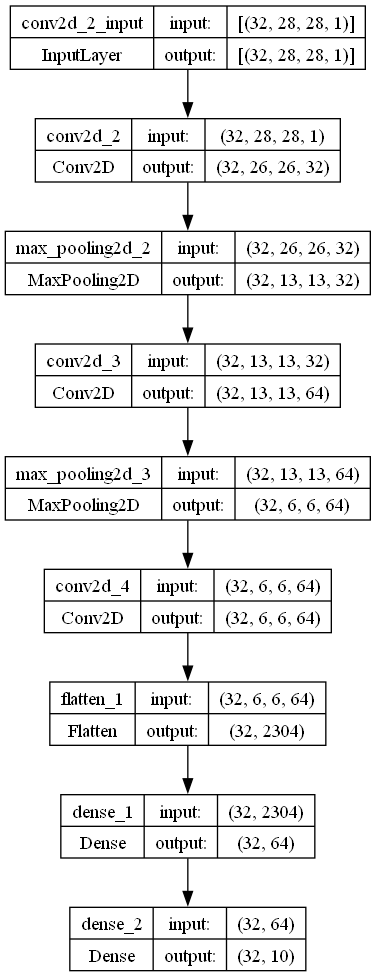

In [6]:
initializer_relu = initializers.random_normal
final_layer_activation = 'softmax'
training_loss = 'categorical_crossentropy'
input_shape = (28, 28, 1)
model = Sequential([Conv2D(32, (3, 3), activation='relu'),
                    MaxPooling2D((2, 2)),                            
                    Conv2D(64, (1, 1), activation='relu'),
                    MaxPooling2D((2, 2)),                            
                    Conv2D(64, (1, 1), activation='relu'),
                    Flatten(),
                    Dense(64, activation='relu'),
                    Dense(10, activation=final_layer_activation, kernel_initializer = initializer_relu)])
model.build(input_shape=(32, 28, 28, 1))
model.summary()
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 trop_conv2d_2 (TropConv2D)  (32, 32, 32, 1)           4         
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 16, 16, 1)          0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (32, 16, 16, 64)          128       
                                                                 
 max_pooling2d_7 (MaxPooling  (32, 8, 8, 64)           0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (32, 8, 8, 64)            4160      
                                                                 
 flatten_3 (Flatten)         (32, 4096)               

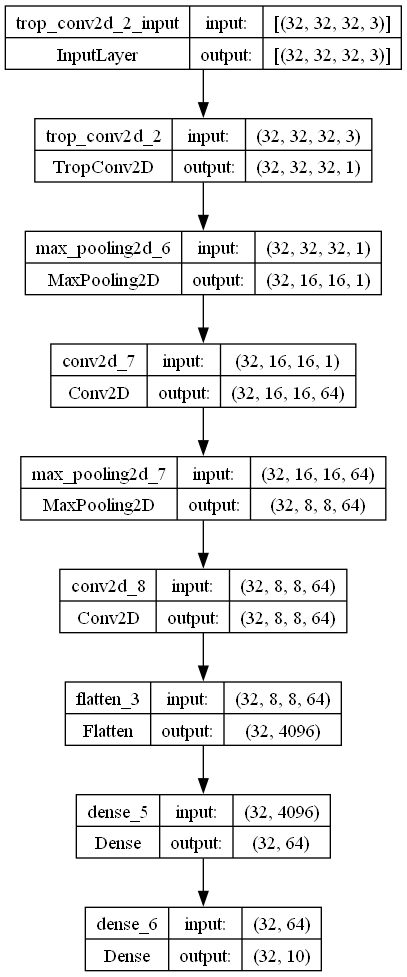

In [8]:
initializer_trop = initializers.random_normal
initializer_relu = initializers.random_normal

model = Sequential([TropConv2D(filters=1, window_size= [1,1,1,1]),
                    MaxPooling2D((2, 2)),                            
                    Conv2D(64, (1, 1), activation='relu'),
                    MaxPooling2D((2, 2)),                            
                    Conv2D(64, (1, 1), activation='relu'),
                    Flatten(),
                    Dense(64, activation='relu'),
                    Dense(10, activation=final_layer_activation, kernel_initializer = initializer_relu)])
model.build(input_shape=(32, 32, 32, 3))
model.summary()
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

### RESULTS: Degradation of prediction power from PGD attack

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

full_data = pd.read_csv('output_data/MNIST_relu_conv_results_30step.csv')
relu_data = full_data[full_data['model_type'] == 'relu']
trop_data = full_data[full_data['model_type'] == 'trop']

col1 = relu_data['maintained_correct_pred']
col2 = trop_data['maintained_correct_pred']
plt.boxplot([col1, col2], labels=[col1.mean(), col2.mean()])
plt.xticks([1, 2], [f'ReLU, {len(relu_data)} experiments', f'Tropical, {len(trop_data)} experiments'])  # Set x-axis labels
plt.xlabel('Model Type')  # Set the x-axis label
plt.ylabel('Portion of Correctly Predicted Labels Maintained')  # Set the y-axis label
plt.title(f'Portion of Correctly Predicted Labels Maintained\nAfter PGD attack on Test Set\n\nReLU mean={round(col1.mean(),3)}---ReLU std={round(col1.std(),3)}\nTrop mean={round(col2.mean(),3)}---Trop std={round(col2.std(),3)}')  # Set the title
plt.show()

col1 = relu_data['pre_acc']
col2 = trop_data['pre_acc']
plt.boxplot([col1, col2], labels=[col1.mean(), col2.mean()])
plt.xticks([1, 2], [f'ReLU, {len(relu_data)} experiments', f'Tropical, {len(trop_data)} experiments'])  # Set x-axis labels
plt.xlabel('Model Type')  # Set the x-axis label
plt.ylabel('Test Set Accuracy')  # Set the y-axis label
plt.title(f'Pre-Attack Test Set Accuracy\n\nReLU mean={round(col1.mean(),3)}---ReLU std={round(col1.std(),3)}\nTrop mean={round(col2.mean(),3)}---Trop std={round(col2.std(),3)}')  # Set the title
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

trop_res = pd.read_csv('output_data/MNIST_trop_conv_pgd_step_test.csv')
relu_res = pd.read_csv('output_data/MNIST_relu_conv_pgd_step_test.csv')

plt.plot(trop_res['num_steps'], trop_res['maintained_correct_pred'], label='Tropical Network')
plt.plot(relu_res['num_steps'], relu_res['maintained_correct_pred'], label='ReLU Network')
plt.title('Test Set Accuracy Maintained After PGD Attack\nas Number of Gradient Steps Increases')
plt.xlabel('Number of Gradient Steps Taken for Attack')
plt.ylabel('Accuracy Maintained After Attack')
plt.xlim((0,40))
plt.legend()
plt.show()

plt.plot(trop_res['num_steps'], trop_res['post_loss'], label='Tropical Network')
plt.plot(relu_res['num_steps'], relu_res['post_loss'], label='ReLU Network')
plt.title('Test Set Loss After PGD Attack\nas Number of Gradient Steps Increases')
plt.xlabel('Number of Gradient Steps Taken for Attack')
plt.ylabel('Post-Attack Loss for Test Set')
plt.xlim((0,40))
plt.legend()
plt.show()

